## Visualization code for making good heatmaps

In [1]:
library(pheatmap)

In [3]:
ref <- readRDS("../../data/amp_phase2_ra/myeloid_reference_2023-03-12.rds")
exp <- readRDS("../../data/amp_phase2_ra/qc_mRNA_314011cells_log_normalized_matrix_2023-03-15.rds")
exp <- exp[, which(colnames(exp) %in% ref$meta_data$cell)]
all(colnames(exp) == ref$meta_data$cell)

# garbage collection: helps release memory, especially for large single-cell data processing
gc()

[1] TRUE

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2586160,138.2,4811628,257.0,NA,4621449,246.9
Vcells,411135018,3136.8,1533967251,11703.3,16384,1731797209,13212.6


In [5]:
# Identify correlations of complement genes and other functional genes
trajectory_gene <-  c("FCGR1A", "TLR4",  "FOLR2", "CCL18",  "CCL13",  "LYVE1",  "COLEC12",  "C3AR1", "C1QA", "C2", "CD59", "CFD", "IFI27", "FCGR3A", 
                      "APOE",   "FABP3",  "S100A4",  "APOBEC3A", "C5AR1",  "C5AR2",  "FOS", "DUSP2", "AREG",  "EREG", "FCER1A", "CD55",  "CFP",  "ICAM3",
                      "G0S2",   "IL1B",   "FCN1",   "MERTK", "MRC1",  "CD163",  "CD68",  "SCARB2" )
traj_exp <- exp[trajectory_gene,]

sparse.cor <- function(x){
  n <- nrow(x)
  m <- ncol(x)
  ii <- unique(x@i)+1 # rows with a non-zero element
  
  Ex <- colMeans(x)
  nozero <- as.vector(x[ii,]) - rep(Ex,each=length(ii)) # colmeans
  covmat <- ( crossprod(matrix(nozero,ncol=m)) +
                crossprod(t(Ex))*(n-length(ii))
  )/(n-1)
  sdvec <- sqrt(diag(covmat))
  covmat/crossprod(t(sdvec))
}
cor_exp <- sparse.cor(t(traj_exp))
dim(cor_exp)


[1] 36 36

In [6]:
# Make row names italic for genes
newnames <- lapply(
  rownames(cor_exp),
  function(x) bquote(italic(.(x))))

paletteLength <- 50
myColor <- colorRampPalette(c("darkblue", "white", "orange"))(paletteLength)
myBreaks <- c(seq(min(cor_exp), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(cor_exp)/paletteLength, max(cor_exp), length.out=floor(paletteLength/2)))


# Make metadata file for column or row names
mat_col <- data.frame(
  # gene =  
  #         c("FCGR1A", "TLR4",  "FOLR2", "CCL18",  "CCL13",  "LYVE1",  "COLEC12",  "C3AR1", "C1QA", "C2", "CD59", "CFD", "IFI27", "FCGR3A", 
  #         "APOE",   "FABP3",  "S100A4",  "APOBEC3A", "C5AR1",  "C5AR2",  "FOS", "DUSP2", "AREG",  "EREG", "FCER1A", "CD55",  "CFP",  "ICAM3",
  #         "G0S2",   "IL1B",   "FCN1",   "MERTK", "MRC1",  "CD163",  "CD68",  "SCARB2" ),
    
  category = c("complement", "complement", "macrophage", "cytokine_chemokine", "cytokine_chemokine", "macrophage", "complement", "complement", "complement", "complement", "complement", "complement", "macrophage", "complement",
               "macrophage", "macrophage", "macrophage", "macrophage", "complement", "complement", "macrophage", "macrophage", "macrophage", "macrophage", "complement", "complement", "complement", "macrophage",
               "macrophage", "cytokine_chemokine", "complement", "macrophage", "macrophage", "macrophage", "macrophage", "macrophage"
               )
)
rownames(mat_col) <- rownames(cor_exp)
    
mat_colors <- list(category = c(complement="#2ca25f", macrophage= "#d95f0e", cytokine_chemokine = "violet")) 

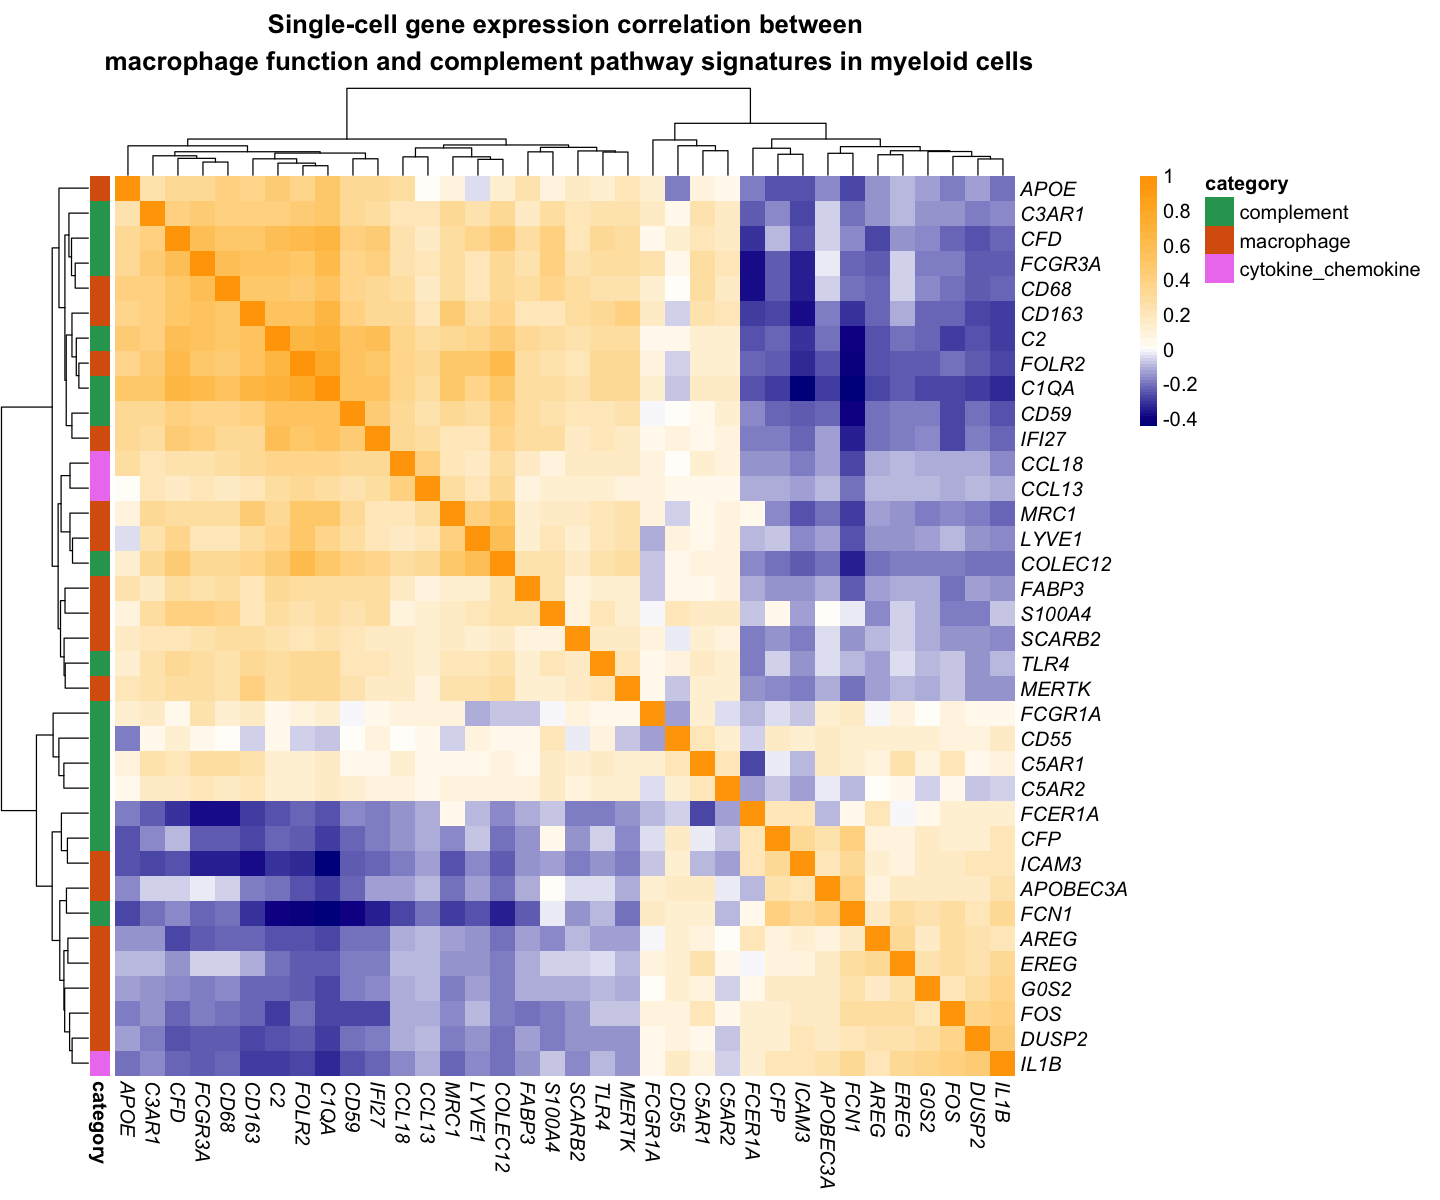

In [7]:
options(repr.plot.height = 10, repr.plot.width = 12)
filename <- "heatmap_cor_traj_gene.pdf"
hm.parameters <- list(
  cor_exp, 
  color  = myColor, # colorRampPalette(rev(brewer.pal(n=7,name="PiYG")))(50), 
  breaks = myBreaks,
  border_color = NA,
  cellwidth = 15, cellheight = 15,
  annotation_row    = mat_col,
  annotation_colors = mat_colors,
  labels_row = as.expression(newnames),
  labels_col = as.expression(newnames),
  show_rownames = T,
  show_colnames = T,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  main = "Single-cell gene expression correlation between\n macrophage function and complement pathway signatures in myeloid cells",
  # cutree_cols = 2,
  # cutree_rows = 2,
  fontsize = 12
  )

# To draw the heat map on screen 
do.call("pheatmap", hm.parameters)


In [8]:
# To draw the plot to a PDF file 
do.call("pheatmap", c(hm.parameters, filename=filename))